# 15 GHP Construction with Duration Matching

In [113]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [115]:
erk.bond_price(20, 1000, 0.05, 2, 0.04)

0    1136.777396
dtype: float64

In [116]:
erk.bond_price(20, 1000, 0.05, 2, 0.05)

0    1000.0
dtype: float64

In [117]:
rates = np.linspace(.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [118]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]

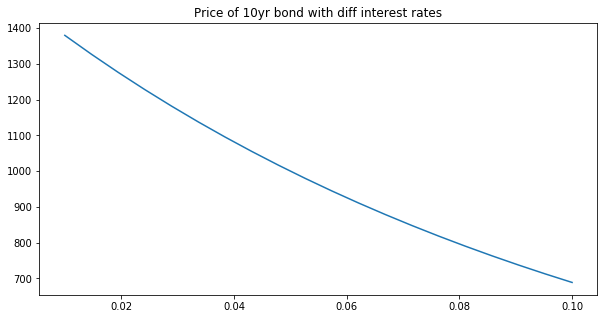

In [119]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10yr bond with diff interest rates", legend=False, figsize=(10,5))

In [120]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [121]:
discounts = erk.discount(cf.index, .06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [122]:
dcf = discounts.mul(cf, axis=0)
dcf

,0
1,29.126214
2,28.277877
3,27.454250
4,26.654611
5,25.878264
6,862.608784


In [61]:
weights = dcf/dcf.sum()
weights

,0
1,0.029126
2,0.028278
3,0.027454
4,0.026655
5,0.025878
6,0.862609


In [123]:
durationV = weights.mul(cf.index, axis=0)
durationV

,0
1,0.029126
2,0.056556
3,0.082363
4,0.106618
5,0.129391
6,5.175653


In [124]:
MacaulayDur = durationV.sum()
MacaulayDur

0    5.579707
dtype: float64

In [125]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

## Duration Matching

In [126]:
liabilities = pd.Series(data=[100000,100000], index=[10,12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [127]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

In [128]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```


In [129]:
short_bond = erk.bond_cash_flows(10, 1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20, 1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [158]:
p_short = erk.bond_price(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
p_flows=pd.concat([a_0*w_s*short_bond/p_short.loc[0],a_0*(1-w_s)*long_bond/p_long.loc[0]])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [159]:
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [162]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)
cfr

0    0.999876
dtype: float64

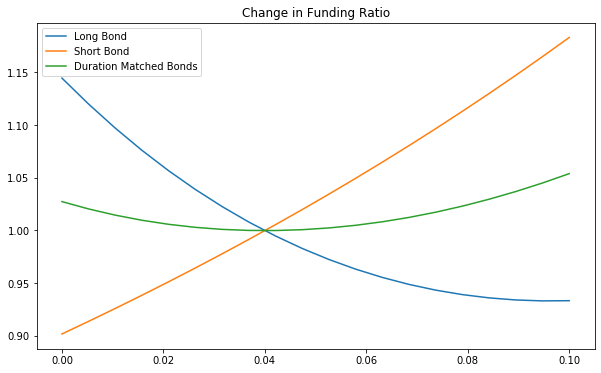

In [205]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0*long_bond/p_long.loc[0]
sb_assets = a_0*short_bond/p_short.loc[0]
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r).loc[0] for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r).loc[0] for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(p_flows, liabilities, r).loc[0] for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6))

## Conclusion

We've seen that if you have the assets on hand, you can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.
